# Homework 5

### CSCI 611, Spring 2024

Jesse Coulson


## Problem Statement
- We are using the mnist dataset of images of handrawn numbers to explore how gridsearch works

### Subtasks
    - Make intial models using SVC and Logstic Regression
    - Use gridsearch to create better models
    - Create visuals and compare results of models

In [22]:
#all the libraries needed for this ipynb
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

## Reading in data and checking 

In [3]:
#read in data
mnist = fetch_openml('mnist_784', as_frame=False, parser = 'auto')

In [4]:
#Split data ino data and target, its already split so read in
X, y = mnist.data, mnist.target

In [6]:
#check shape of data
X.shape

(70000, 784)

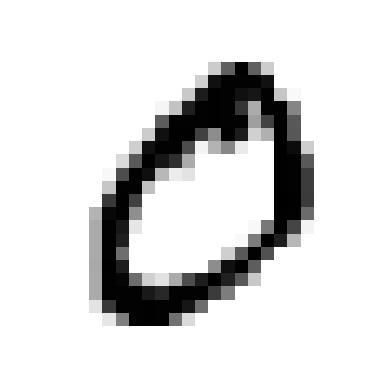

In [28]:
#code from Homl3 to see example of handwritten number
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[1]
plot_digit(some_digit)
plt.show()

In [8]:
#split data into training and testing. Data is specifically first 60,000 for training and last 10,000 for testing
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Creating Initial Models
 - For both models I am using the complete default parameters except for random state
 - Using StandardScaler to scale the pixel values to close to each other. This is really only more impactful for SVC but I did for both it should help some
 - I also used PCA. This reduces dimensionality. With a value of .95, it makes sure it only loses up to 5% variance max while decreasing the dimensionality.

In [10]:
SVC_clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    SVC(random_state=42)
)
SVC_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('svc', SVC(random_state=42))])

In [11]:
log_clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    LogisticRegression(random_state=42)
)
log_clf.fit(X_train, y_train)

/home/jcccoulson/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression', LogisticRegression(random_state=42))])

### Initial Model Conclusion
After creating the inital models something of note is that the logistic regression model did not converge with default hyperparameters. This is fine it will still be able to predict it is just not optimal. For my gridsearch I will make sure it converges. I will show the metrics further in the notebook when comparing to the gridsearched hyperparameters.

# Gridsearch on models
 - Ran gridsearch on both models taking multiple days to run
 - I could not run on my notebook because of this, ran as script
 - will still show code in sell, but ran outside and have screenshot of output.

## Gridsearch on SVC
 - Ran grisearch on svc
 - Made hyperparameter options for C, kernel type, gamma, and shrinking
### Explanations for Hyper Parameters
 - C
    - C represents the regularization parameter, the smaller the C is the more generalization is allowed, kind of like opposite of alpha in regression. Chose varying levels to see if we want a fit that is very close to training data or we want to be more generalized so chose 3 different values of .1, 1, and 10
 - kernel
     - Chose linear, poly, and rbf for options for kernel. Linear is the regular svm, for linear the decision boundary line will have to be straight. For poly it will be higher dimension and non linear. By default poly level is 3 which is a good enough check for polynomial. Rbf is another kernel that can handle non linear, these three are a good range of options for what is the optimal kernel
 - gamma
     - kernel coefficient that affects how much each kernel will be scaled. Only relevant to rbf and poly kernels. When gamma is scale it is 1 / (n_features * X.var()). When gamma is auto it is 1 / n_features. These vals are from scikit learn documentation
 - shrinkng
     - there is an optional shrinking heuristic to optimize svc, true if you want it false if not


In [ ]:
SVC_clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95)
    #svc takes a lot of iterations to converge, -1 runs until it converges without a limit
    SVC(random_state=42, max_iter = -1)
)

param_grid = {
    'svc__C': [0.1, 1, 10],  
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc_gamma' : ['auto', 'scale'],
    'svc__shrinking': [True, False], 
}
#5fold kfold and using all cores possible for parallelization
grid_search_svc = GridSearchCV(SVC_clf, param_grid, cv=5, n_jobs = -1)
grid_search_svc.fit(X_train, y_train)

#printing the optimal hyperparametrs and accuracy of the model
print("Hypereparams of best svc model:", grid_search_svc.best_params_)
print("Accuracy score of best svc model:", grid_search_svc.best_score_)

### SVC GridSearch output
![title](svcoutput.jpg)

## Gridsearch on Logstic Regression
 - Ran grisearch on LogisticRegression
 - Made hyperparameter options for C, solver, penalty and max_iter
### Explanations for Hyper Parameters
 - C
    - The regulurization paramter. The higher the value of C the more regulurization or generilization there is. Chose 3 values .1, 1, and 10 to get wide range of values.
 - solver
     - The default solver is lbfgs. According to the documentation, saga is good for large dataset and liblinear is good for small datasets. This is a good range of kernels for different scenarios so i chose all three to find optimal.
 - penalty
     - based on the solver you can add penalty of l1, l2, or elasticnet to add to cost function. liblinear allows l1 and l2, lbfgs allows l2, and saga allows both. So I chose these two to find the optimal that they accept.
 - max_iter
     - Unlike svc, this can converge on a lower max_iter. I chose to optimize between 5,000 and 10,000 max iterations, this will help us optimize our runtime if we find that 5,000 iterations is enough in the best combination of hyperparameters. I chose these two numbers by expirementing with max_iter before hand.


In [ ]:
log_clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    LogisticRegression(random_state=42)
)
param_grid = {
    'logisticregression__C': [0.1, 1, 10],  
    'logisticregression__solver': ['saga', 'liblinear', 'lbgfs'],  
    'logisticregression__penalty': ['l1', 'l2'],  
    'logisticregression__max_iter': [5000, 10000],
    
}

grid_search_log = GridSearchCV(log_clf, param_grid, cv=5, n_jobs = -1)
grid_search_log.fit(X_train, y_train)

### logistic regression GridSearch output
![logisticregression_output.jpg](logisticregression_output.jpg)

## GridSearch Conclusions
Through gridsearch I was able to find the optimal hyperparameters for svc and logistic regression model. For svc I found a model with 97% accuracy, and for logistic regression I was able to find a model with 92% accuracy. For each of the gridsearches I did 5 fold cross validation with all the different combinations. All thes combinations and cross validations caused the creation of over 100 models each on such a large dataset. This caused the runtime to be over 2 days. I also tried to use n_jobs = -1 as a hyper param on gridsearch to make it go in parallel. -1 makes it use as many available cores as possible. The next step is to explore these hyperparameters on the test set.

# Final Metrics and Comparison

## Metrics for initial models

Accuracy on test set:  0.9686
Precision:  0.9686234453592111
Recall:  0.9682560654940733
F1 score:  0.9683721337326313


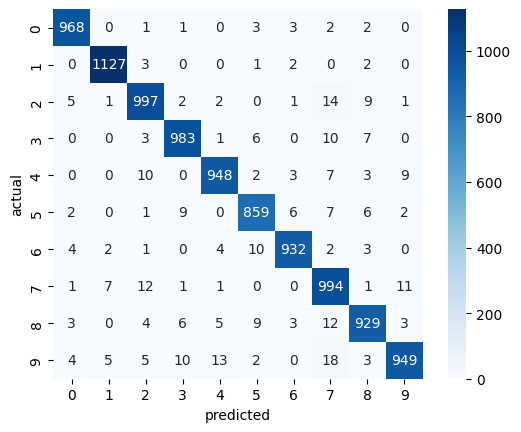

In [26]:
#SVC initial metrics
y_pred = SVC_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ",acc)

#proportion of positives that were correctly identifed out of all actual positives
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

#how many positives were correctly identified
recall = recall_score(y_test, y_pred, average='macro') 
print("Recall: ", recall)

#metric that combines precision and recall
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score: ", f1)


#creating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual');

Accuracy on test set:  0.9265
Precision:  0.9257553730164894
Recall:  0.9254398382297785
F1 score:  0.9255074592476484


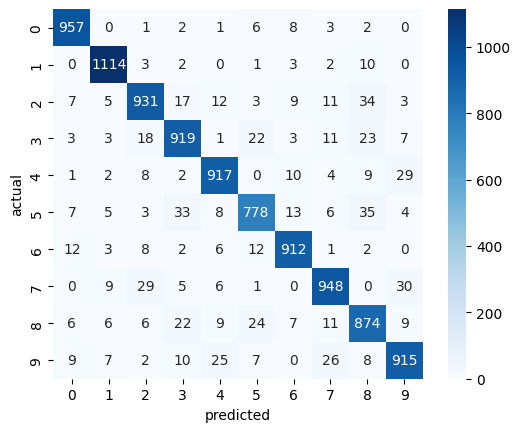

In [27]:
#logistic regression initial metrics
y_pred = log_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ",acc)

#proportion of positives that were correctly identifed out of all actual positives
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

#how many positives were correctly identified
recall = recall_score(y_test, y_pred, average='macro') 
print("Recall: ", recall)

#metric that combines precision and recall
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score: ", f1)


#creating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual');

### Initial Metrics conclusion
The SVC model performs significantly better than the logistic regression confusion matrix. It is 96.8% accuracy while the logistic regression model was 92.6% accuracy. These are very good performances for the default hyperparameters but are not as optimal is it could be when we gridsearch. 

The precision, recall, and f1 scores are very similar. This is good. Precision is how many it correectly classified divided by how many correctly classified over how many it incorrectly classified. .92 shows that it had very little false positives. Recall or sensitivity measures how many it correctly classfied divided by how many it correctly classified and how many it missed. The high value shows it did not have many false negatives. F1 score is the mean harmonic of these two metrics. These metrics are all very solid and tehre is nothing that is cause for concern. 

Looking at the confusion matrix you can gain lots of insights. For example 1s are almost always correctly classified, it barely incorrectly classifies it as another number.  You can also see things such as the most likely misclassification for 2 is the number 8. which makes sense since the numbers are slightly similar. This matrix helps see which feautures of the number is probably most important.

## Gridsearch models with test set metrics

In [15]:
#Creating model off of optimal hyperparametrs found from gridsearch for SVC
SVC_grid_clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    SVC(C = 10, gamma = 'auto', kernel = 'poly', shrinking = True, random_state=42, max_iter = -1)
)
SVC_grid_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('svc',
                 SVC(C=10, gamma='auto', kernel='poly', random_state=42))])

In [16]:
#optimal hyperparams for logistic regression
log_grid_clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    LogisticRegression(C = 0.1, max_iter = 5000, penalty = 'l2', solver = 'lbfgs', random_state=42)
)
log_grid_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=5000, random_state=42))])

## Metrics for gridsearch models

Accuracy on test set:  0.9782
Precision:  0.9779532465278326
Recall:  0.9779153105850152
F1 score:  0.9779192981784732


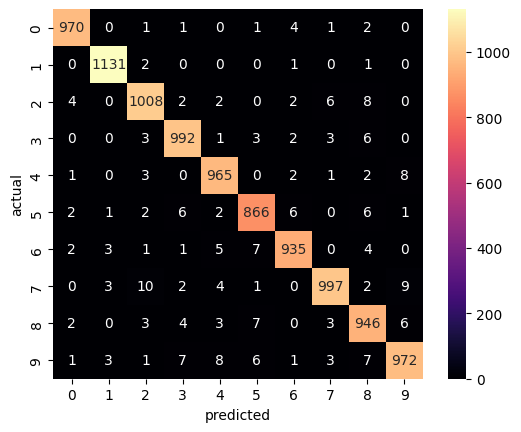

In [23]:
#SVC gridsearch metrics
y_pred = SVC_grid_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ",acc)

#proportion of positives that were correctly identifed out of all actual positives
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

#how many positives were correctly identified
recall = recall_score(y_test, y_pred, average='macro') 
print("Recall: ", recall)

#metric that combines precision and recall
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score: ", f1)


#creating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="magma", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual');

Accuracy on test set:  0.928
Precision:  0.9272959345876897
Recall:  0.9269549583906234
F1 score:  0.927022312974238


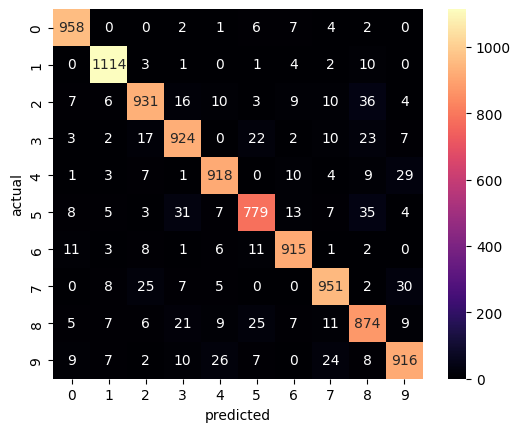

In [24]:
#logistic regression gridsearch metrics
y_pred = log_grid_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ",acc)

#proportion of positives that were correctly identifed out of all actual positives
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

#how many positives were correctly identified
recall = recall_score(y_test, y_pred, average='macro') 
print("Recall: ", recall)

#metric that combines precision and recall
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score: ", f1)


#creating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="magma", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual');

### Gridsearch Model Conclusion and comparison with initial models
The performance of the grid search is better than the intial models, but not by too much. This makes sense because the intial models were already so high performance. But the gridearch optimization is more importance, in the real world a difference of .05% accuracy could be the difference of thousands of dollars. 

For the gridsearch models the SVC was 97.8% accuracy and the logistic regression accuracy was 92.8%. This is 1% better than intial model for SVC and .15% better than intial model for logstic regression. Overall the precision and recall is proportionally the same as the initial so the conclusions drawn earlier stay true to these models. Once again there is lots of extra information available from the confusion matrix. 

One thing I notice is that it appears 8 is the most mosclassified number. This makes sense because if someone draws an 8 with some segment missing it will look close to something like a 5 or a 3. So overall the gridsearch found measurable improvement over default hyperparametrs and both these models are very accurate. 

The best final model was the SVC which had signficantly better metrics the the logistic regression models in every metric.